# QML for VBS 

#### Imports
dfkvj dvjkdjvdldfklmmssk mfsòf g mggs

In [ ]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import time
import pickle
import random 
from random import randrange

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

#### Script parameters

In [3]:
quantum_hw = 0
bknd = 'ibmq_athens'
Shots = 8192                        #number of attempts for each measuration to get a statistical result
max_circuits_supported = 7400         #use an number multiple of number_classes
layout = [0,1,2,3,4]

number_training = 350 #125               #number of events of each type used during the training phase
number_testing = 200                #number of events of each type used during the testing phase
SPSA_steps = 100                     #number of steps for SPSA algorithm (original: 100)
number_var = 5                      #total number of variables used to classify each event
number_classes = 2                  #number of classes for which classification is performed
ratio = 1 #0.18145139685943007         #ratio probability_signal/ probability_event

#numbers associated to the variables used for the classification of each event (their order is relevant):
ii = 35
jj = 40
kk = 43
ll = 54 
mm = 45


c_e_ii = 23.807574615434635
c_e_jj = 8.177020948034661
c_e_kk = 7.568297786037082
c_e_ll = 7.194341957347005
c_e_mm = 4.532632440369189 


L1 = 1                 #Number of repetitions of the Mapping Circuit
L2 = 2                 #Number of repetitions of the Variational part of the Quantum Circuit


print_loss_func = 1     #1: prints the loss function evaluations, 0: doesn't
plot_AUC_image = 1      #1: prints the AUC graph, 0: doesn't
plot_data = 1           #1: prints the data images, 0: doesn't

#### Definitions of useful functions

In [4]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

In [5]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

In [6]:
def softmax_function(x):
    F = [math.exp(x[0]),math.exp(x[1]),math.exp(x[2]),math.exp(x[3])]
    for i in range(0,2):
        F[i] = F[i]/sum([math.exp(x[0]),math.exp(x[1])])
    for i in range(2,4):
        F[i] = F[i]/sum([math.exp(x[2]),math.exp(x[3])])
    return F
  
#the following gives a two dimensional unitary vector obtained from results of measurations from the qubits   

# def f_measuration(count):
#     Z_m = np.zeros(2)
#     for i in range(0,2**(number_bits)):
#         for k in range(0,2):
#             if eig[i][1-k] == '0' and eig[i] in count:
#                 Z_m[k] += count[eig[i]]  

#     Z_m = (2*np.array(Z_m)-Shots)/Shots
#     y = softmax_function(Z_m)
#     return y

def f_measuration(count):
    Z_m = np.zeros(4)
    for i in range(0,2**(number_bits)):
        for k in range(0,4):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

In [7]:
#definition of the mapping auxiliary function phi 
def Phi_function(x,y,z,a,b):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2),np.arcsin(z),np.arccos(z**2),np.arcsin(a),np.arccos(a**2),np.arcsin(b),np.arccos(b**2)] 
    #the length of the array has to be equal to the number of qubits

In [8]:
def training_set(par,circuit,theta,Phi_f):
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]

    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw == 1:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts

    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw == 1:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    Counts = Counts + counts
    counts = Counts
    
    ### Just to check that the circuits look right...
    print(circuits_dataset[0].decompose())
    
    return counts

<IPython.core.display.Javascript object>


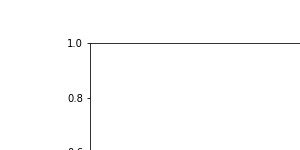

In [9]:
%matplotlib notebook

X_plot = []
Y_plot = []

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
iter_count = 0

def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   
    


def cost_function(par,*args): #par will contain the parameters at each step of the optimization

    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
        
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            Yi = ((c_e_ii+c_e_jj)*yi[k] + (c_e_kk+c_e_ll)*yi[2+k])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)           
            L += (-f_l[i][k]*math.log(Yi))*(((i+1)%2)*ratio + i%2)
            
    if print_loss_func == 1:
        plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

#### Loading data for training

<IPython.core.display.Javascript object>


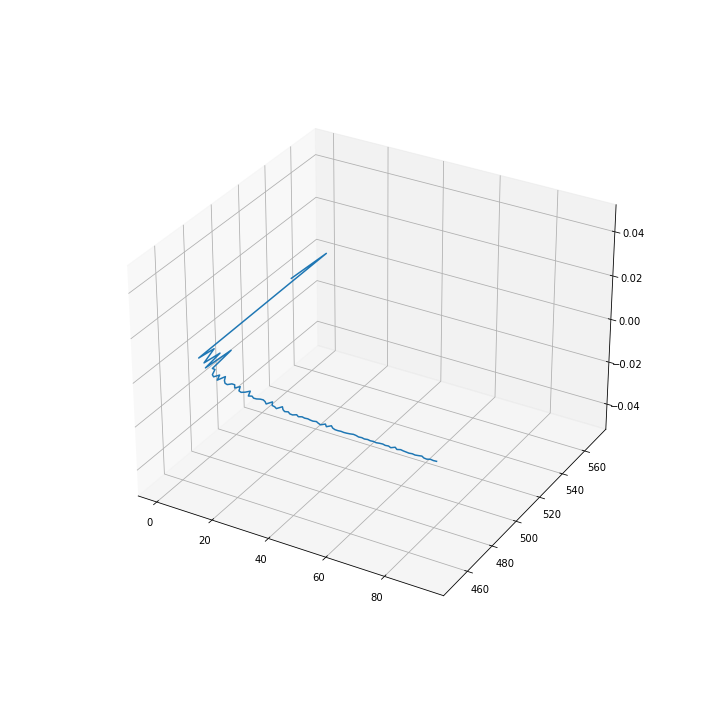

In [10]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the previous functions.
#Odd and even elements of the following vectors will apparain to different classes (by choice)

data2 = pickle.load(open("background_balanced.pkl","rb"))
data1 = pickle.load(open("signal_balanced.pkl","rb"))
Ind = data1.columns
n = 0 #number_testing
#start = randrange(8000)
start = 0

X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

XX = []
for i in range(start, start + number_training + n):
    XX.append(X1[i])
    XX.append(X2[i])

Xmax = max(max(XX),max(XX))
Xmin = min(min(XX),min(XX))

X = []
for i in range(0,number_training):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])

YY = []
for i in range(start, start + number_training + n):
    YY.append(Y1[i])
    YY.append(Y2[i])

Ymax = max(max(YY),max(YY))
Ymin = min(min(YY),min(YY))


Y = []
for i in range(0,number_training):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)  -1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

ZZ = []
for i in range(start, start + number_training + n):
    ZZ.append(Z1[i])
    ZZ.append(Z2[i])

Zmax = max(max(ZZ),max(ZZ))
Zmin = min(min(ZZ),min(ZZ))


Z = []
for i in range(0,number_training):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)  -1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################
A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

AA = []
for i in range(start, start + number_training + n):
    AA.append(A1[i])
    AA.append(A2[i])

Amax = max(max(AA),max(AA))
Amin = min(min(AA),min(AA))


A = []
for i in range(0,number_training):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

BB = []
for i in range(start, start + number_training + n):
    BB.append(B1[i])
    BB.append(B2[i])

Bmax = max(max(BB),max(BB))
Bmin = min(min(BB),min(BB))

B = []
for i in range(0,number_training):
    B.append(B1[i])
    B.append(B2[i])

#X are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B) -1
#X = Sqrt(B)
B = np.clip(B,-1,1)

############################################################

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []


for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TRAINING SET VISUALIZATION
if plot_data == 1:
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 2)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 2)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')    

#### Preparing for the training

In [11]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [12]:
number_qubits = 1 #for EACH variable
number_bits = number_classes*2

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

In [13]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [14]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

<IPython.core.display.Javascript object>


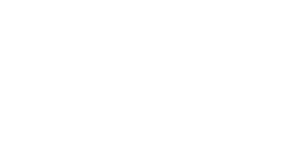

<IPython.core.display.Javascript object>

In [15]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement  

    circuit.cx(0,1)
    circuit.cx(2,3)
    circuit.h(3)
    circuit.cx(2,3)
    circuit.cx(3,4)
    circuit.cx(2,3)

    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
# circuit.measure(range(0,2),range(0,2))
circuit.measure(range(0,4),range(0,4))

decomposed_circuit = circuit.decompose()
decomposed_circuit.draw('mpl')

#### Training

In [16]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]    

In [ ]:
#initial values for parameters are chosen randomly
theta_0 = []

for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(max_trials = 1e3, save_steps = 1, last_avg = 1, c0 = 10/(number_training), c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

# cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
#     Optimizer._optimization(cost_function,theta_0, SPSA_steps, save_steps = 1, last_avg = 3))

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)
%matplotlib inline

C:\Users\dado\anaconda3\lib\site-packages\qiskit\aqua\components\optimizers\spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐  ┌──────────────────────┐  ░                 »
«q_0: ┤ RX(5.59868391783334) ├──┤ RZ(1.41277826


 current value of parameters:  [ 4.99868392  2.01277827  3.23663447  2.1560176   4.96197941  0.52889754
  6.38239383  2.54822061  4.70429366 -0.22200061  0.83575185  3.54306897
  0.70468398  1.15393689  3.24020578  4.50275982  5.18521162  1.60759081
  1.82465903  2.97315332]
current value for loss function:  570.7174040273065 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2

current value for loss function:  479.7653332317548 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐┌───────────────────────┐  ░            


 current value of parameters:  [ 6.04139381  0.97006838  4.27934436  0.12208436  3.20612401 -0.79189019
  5.33968394  3.86900833  6.73822689  1.09878711 -0.92010355  1.50913574
 -0.33802591 -0.60191851  1.20627255  5.54546971  6.22792151  2.92837854
  3.85859227  5.00708656]
current value for loss function:  468.39472635111633 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 5.87284023  1.13862195  4.11079079 -0.04646921  3.37467758 -0.73308628
  5.28088003  3.81020442  6.90678047  1.26734069 -0.75154998  1.56793965
 -0.16947233 -0.43336494  1.26507646  5.37691613  6.28672542  2.86957463
  4.02714584  5.17564013]
current value for loss function:  465.4134848595633 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2

current value for loss function:  466.38400768432757 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐┌───────────────────────┐  ░           


 current value of parameters:  [ 6.13780168  1.04483749  3.28244766  0.21849223  3.10971614 -0.99804772
  5.37466449  3.15303828  6.81299601  1.00237924  0.07679314  2.39628277
 -0.26325679  0.2238012   1.92224259  5.64187758  7.11506854  2.96335909
  3.7621844   4.91067869]
current value for loss function:  462.35841643046 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.202


 current value of parameters:  [ 6.23724822  0.99061632  3.18300112  0.16427107  3.16393731 -0.94382656
  5.27521795  3.25248483  6.75877484  1.05660041  0.17623969  2.3420616
 -0.31747796  0.27802237  1.97646376  5.74132412  7.06084737  2.86391254
  3.81640556  4.96489985]
current value for loss function:  463.54051821649836 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.02861698  1.05929262  3.25167742  0.37290231  3.09526101 -1.01250286
  5.4838492   3.18380853  6.82745114  0.98792411  0.10756339  2.4107379
 -0.24880166  0.06939112  1.90778746  5.53269288  7.12952367  2.93258884
  3.60777432  4.89622356]
current value for loss function:  463.63870577346927 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.13299675  1.2925512   3.3560572   0.13964373  2.86200243 -1.11688263
  5.25059062  2.95054995  7.06070972  0.88354433 -0.12569519  2.64399648
 -0.14442188  0.1737709   1.80340768  5.76595146  7.36278225  3.16584742
  3.71215409  4.66296497]
current value for loss function:  459.3122360735542 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.09783667  1.20799554  3.44061286  0.10448365  2.82684235 -1.20143829
  5.33514628  3.03510561  6.97615406  0.79898867 -0.04113953  2.67915656
 -0.17958196  0.25832656  1.83856776  5.6813958   7.27822659  3.2010075
  3.67699402  4.62780489]
current value for loss function:  460.2391156821729 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20

current value for loss function:  458.1196733525211 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐  ░            


 current value of parameters:  [ 6.29137421  1.29616128  3.24707532  0.20212656  2.91500808 -1.10379539
  5.14160874  2.9374627   7.0643198   0.79125978 -0.03341064  2.59099082
 -0.09141622  0.06478903  1.64503023  5.67366691  7.2704977   3.00746997
  3.87053155  4.7254478 ]
current value for loss function:  457.127660485957 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20

current value for loss function:  457.47149682159426 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░            


 current value of parameters:  [ 6.37155962  1.21597587  3.20559884  0.28231197  2.83482267 -1.11820355
  5.10013226  2.95187086  7.11743689  0.7497833   0.00806584  2.53787373
 -0.13289271 -0.01539639  1.56484482  5.63219042  7.19031229  3.06058706
  3.95071696  4.80563321]
current value for loss function:  455.66479888600196 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 6.4438431   1.23382613  3.13331537  0.35459545  2.85267293 -1.10035329
  5.11798252  3.02415434  7.18972037  0.67749982  0.08034932  2.55572399
 -0.20517618 -0.08767986  1.58269508  5.55990695  7.20816255  3.0427368
  4.02300044  4.78778295]
current value for loss function:  455.305720341908 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.202


 current value of parameters:  [ 6.37617745  1.16616048  3.11482864  0.37308217  2.87115966 -1.08186656
  5.05031687  3.04264106  7.20820709  0.74516547  0.09883604  2.57421072
 -0.22366291 -0.10616659  1.51502943  5.54142022  7.1404969   3.02425007
  4.04148716  4.8554486 ]
current value for loss function:  455.9541080129615 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.47289732e+00  1.18030755e+00  3.21154851e+00  2.76362302e-01
  2.85701258e+00 -1.09601363e+00  5.14703674e+00  3.02849399e+00
  7.11148722e+00  6.48445601e-01  2.11617312e-03  2.56006365e+00
 -2.09515839e-01 -9.44672008e-03  1.61174930e+00  5.63814009e+00
  7.23721677e+00  3.03839714e+00  4.02734009e+00  4.84130153e+00]
current value for loss function:  455.3316652589893 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├───────────────


 current value of parameters:  [ 6.48639408e+00  1.16681079e+00  3.22504527e+00  2.62865542e-01
  2.79117514e+00 -1.08251687e+00  5.16053350e+00  2.96265654e+00
  7.17732467e+00  7.14283049e-01  6.79536215e-02  2.57356041e+00
 -1.43678390e-01  4.05004075e-03  1.62524606e+00  5.65163685e+00
  7.25071353e+00  3.10423459e+00  4.04083685e+00  4.77546408e+00]
current value for loss function:  456.55765333378474 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├──────────────


 current value of parameters:  [ 6.35819643  1.29500844  3.09684762  0.39106319  2.91937279 -1.13432677
  5.1087236   3.0908542   7.04912702  0.66247315 -0.06024403  2.52175051
 -0.27187604 -0.04775986  1.49704841  5.5234392   7.12251588  3.05242469
  3.9126392   4.90366173]
current value for loss function:  453.91551794801256 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 6.35344717  1.22606402  3.09209836  0.39581245  2.85042836 -1.12957752
  5.03977918  3.02190977  7.11807144  0.6672224   0.00870039  2.45280608
 -0.2766253  -0.0430106   1.56599283  5.59238363  7.19146031  3.05717395
  3.90788995  4.83471731]
current value for loss function:  455.3778923249484 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.39914895  1.27176579  3.13780014  0.27889136  2.89613014 -1.2464986
  5.15670026  3.13883086  7.00115036  0.55030132 -0.10822069  2.56972717
 -0.23092352 -0.15993169  1.44907175  5.47546254  7.14575853  3.01147217
  3.95359172  4.95163839]
current value for loss function:  452.76855508323547 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.45167735  1.25535672  3.19032854  0.33141977  2.87972107 -1.1939702
  5.10417186  3.08630245  6.98474128  0.53389224 -0.12462976  2.51719877
 -0.24733259 -0.10740329  1.43266267  5.52799094  7.09323012  2.95894377
  4.00612013  4.96804747]
current value for loss function:  452.32314157258907 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.4019943   1.23821435  3.20747092  0.28173671  2.86257869 -1.24365326
  5.15385492  3.06916008  6.96759891  0.51674987 -0.07494671  2.56688182
 -0.19764954 -0.15708634  1.4155203   5.54513332  7.14291318  3.00862682
  4.0232625   4.98518984]
current value for loss function:  453.0806405908362 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.41978289  1.25600293  3.18968233  0.2995253   2.94523123 -1.16100072
  5.07120238  3.15181261  6.9853875   0.53453846 -0.15759925  2.54909324
 -0.21543813 -0.07443381  1.43330889  5.46248078  7.12512459  2.99083823
  3.94060997  4.90253731]
current value for loss function:  452.8112903599408 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.49540197  1.26858535  3.17709991  0.31210772  2.93264881 -1.17358314
  5.0837848   3.07619353  7.06100658  0.54712088 -0.14501683  2.47347415
 -0.22802055 -0.08701623  1.50892797  5.53809987  7.11254217  2.91521914
  3.95319239  4.91511973]
current value for loss function:  452.6457520429586 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.49118689  1.27280044  3.11155526  0.37765237  2.92843373 -1.23912779
  5.08799988  3.08040861  6.99546193  0.61266553 -0.07947217  2.5390188
 -0.2935652  -0.15256088  1.50471289  5.47255522  7.04699752  2.91943423
  3.95740747  4.91933481]
current value for loss function:  452.1645794051543 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20

current value for loss function:  451.84701653377687 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░            


 current value of parameters:  [ 6.42156567  1.34242166  3.15577078  0.39166603  2.94244738 -1.19491227
  5.1322154   3.15002983  7.06508315  0.62667919 -0.09086422  2.52762675
 -0.28217315 -0.14116883  1.51872655  5.45854156  7.03298386  2.96364974
  4.00162299  4.96355033]
current value for loss function:  452.7109180051431 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.50313137  1.31767221  3.13102133  0.31010032  2.91769794 -1.21966172
  5.0506497   3.06846413  7.04033371  0.54511348 -0.11561366  2.44606105
 -0.20060745 -0.05960313  1.49397711  5.483291    7.11454957  2.9389003
  3.97687354  4.93880088]
current value for loss function:  452.78075239142635 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.47605935  1.23511637  3.10394931  0.39265617  2.83514209 -1.30221757
  5.13320555  3.09553615  7.01326168  0.57218551 -0.14268569  2.47313308
 -0.22767947 -0.14215898  1.41142126  5.51036303  7.08747754  2.91182827
  3.8943177   4.85624504]
current value for loss function:  451.0350688044509 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.48461614  1.22655957  3.05828129  0.34698816  2.88081011 -1.31077436
  5.14176234  3.14120417  6.96759367  0.56362871 -0.13412889  2.46457628
 -0.21912268 -0.09649096  1.45708928  5.55603105  7.04180952  2.86616026
  3.8857609   4.90191305]
current value for loss function:  451.14083619878676 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.

current value for loss function:  451.0615601595897 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░             


 current value of parameters:  [ 6.47894201  1.2322337   3.1158583   0.40140983  2.87513598 -1.25635269
  5.08734067  3.08362716  7.02201534  0.61805039 -0.13664768  2.52215329
 -0.22479681 -0.15406797  1.39951226  5.49845403  7.04748365  2.92373727
  3.94018257  4.84433604]
current value for loss function:  451.6066936440839 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2

current value for loss function:  450.95684834170527 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░            


 current value of parameters:  [ 6.41531693  1.23143851  3.10204174  0.3523965   2.8115109  -1.31997777
  5.15096575  3.13264049  7.00819878  0.56903706 -0.1358525   2.52294848
 -0.22400162 -0.14025141  1.44852559  5.54746736  7.04668846  2.87472394
  3.89116924  4.89334937]
current value for loss function:  450.80379827684465 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 6.41033408  1.2752916   3.05818866  0.39624958  2.80652805 -1.27612468
  5.10711266  3.13762334  7.01318163  0.61289014 -0.17970558  2.4790954
 -0.26785471 -0.09639833  1.40467251  5.50361428  7.04170561  2.86974109
  3.93502233  4.84949629]
current value for loss function:  450.8112086638563 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20


 current value of parameters:  [ 6.4542106   1.27932331  3.10206517  0.35237307  2.80249634 -1.3200012
  5.15098917  3.09374683  6.96930512  0.56901363 -0.18373729  2.47506369
 -0.27188642 -0.09236662  1.4006408   5.49958257  7.03767391  2.86570938
  3.89114581  4.8933728 ]
current value for loss function:  450.7149647106258 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20


 current value of parameters:  [ 6.41135299  1.2364657   3.05920756  0.39523068  2.84535395 -1.32416576
  5.10813156  3.08958226  7.01216273  0.56484906 -0.14087968  2.47089912
 -0.22902881 -0.08820205  1.39647623  5.54244018  7.08053152  2.86154481
  3.88698125  4.85051519]
current value for loss function:  451.1437225108381 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.46026011  1.28537282  3.06193977  0.39249847  2.79644683 -1.27525864
  5.15703868  3.09231447  7.00943051  0.56758128 -0.14361189  2.47363134
 -0.27793593 -0.13710917  1.44538335  5.53970797  7.0777993   2.86427703
  3.93588837  4.89942231]
current value for loss function:  450.9931919631097 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.41094599  1.2360587   3.11125389  0.34318435  2.84576095 -1.27920898
  5.10772456  3.09626481  6.96011639  0.57153161 -0.14756223  2.47758167
 -0.22862181 -0.08779505  1.39606923  5.53575763  7.02848518  2.86822737
  3.88657425  4.85010819]
current value for loss function:  451.4883657761307 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.42882142  1.25393413  3.04879204  0.36105978  2.7832991  -1.29708442
  5.17018641  3.15872666  6.97799183  0.58940705 -0.16543767  2.49545711
 -0.24649724 -0.15025691  1.41394467  5.47329578  7.04636062  2.93068922
  3.90444968  4.91257004]
current value for loss function:  451.0313429393215 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2


 current value of parameters:  [ 6.482273    1.3073857   3.05840299  0.37067073  2.79291005 -1.30669536
  5.11673484  3.10527509  6.98760277  0.64285862 -0.21888924  2.54890868
 -0.25610819 -0.14064596  1.42355562  5.52674735  7.09981219  2.87723765
  3.91406063  4.90295909]
current value for loss function:  450.60092398205546 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 6.44104191  1.30927905  3.09963407  0.36877738  2.7910167  -1.30480202
  5.15796593  3.14650617  6.98570943  0.64475197 -0.22078258  2.5076776
 -0.29733927 -0.1425393   1.4647867   5.52864069  7.10170553  2.8753443
  3.91216729  4.90485244]
current value for loss function:  450.6855494400684 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.202


 current value of parameters:  [ 6.48780592  1.30495104  3.09530606  0.37310539  2.83778071 -1.30913003
  5.15363792  3.09974217  7.03247343  0.59798796 -0.17401858  2.51200561
 -0.25057527 -0.0957753   1.46045869  5.48187669  7.05494153  2.87967231
  3.95893129  4.85808843]
current value for loss function:  450.69534827090007 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.


 current value of parameters:  [ 6.4413721   1.25851722  3.0906459   0.37776556  2.79134689 -1.35556385
  5.14897775  3.10440233  7.02781327  0.64442178 -0.2204524   2.51666577
 -0.25523543 -0.14220912  1.45579853  5.52831051  7.10137535  2.92610613
  3.91249747  4.8627486 ]
current value for loss function:  450.2448670781373 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.2

current value for loss function:  450.6760209004451 


Job Status: job has successfully run
global phase: -4.66384771862971
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.740339627019496,0) ├─┤ U1(2.87907903295892) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      ├────────────────────────┤└┬──────────────────────┤ ░ »
q_2: ─┤ R(-1.22486497974254,0) ├─┤ U1(2.46800340577799) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_3: ─┤ R(-1.82697608841606,0) ├─┤ U1(1.78698717627837) ├─░─»
      ├────────────────────────┤ ├──────────────────────┤ ░ »
q_4: ─┤ R(-2.27736788014919,0) ├─┤ U1(1.20255019133094) ├─░─»
      └────────────────────────┘ └──────────────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░             


 current value of parameters:  [ 6.47954118  1.2966863   3.11124486  0.39768783  2.82951597 -1.37616281
  5.15132991  3.14257142  7.00789099  0.62449951 -0.24105137  2.51431361
 -0.27515771 -0.16280809  1.43587625  5.49014143  7.10372751  2.88793705
  3.91014531  4.86039644]
current value for loss function:  450.5698783626601 




#### Load data for testing

In [ ]:
#data capture
# data2 = pickle.load(open("Wjets_part1.pkl","rb"))
# data1 = pickle.load(open("VBS_part1.pkl","rb"))
# Ind = data1.columns


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

X = []
for i in range(start + number_training, start + number_training + number_testing):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])


Y = []
for i in range(start + number_training, start + number_training + number_testing):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)-1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

Z = []
for i in range(start + number_training, start + number_training + number_testing):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)-1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################

A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

A = []
for i in range(start + number_training, start + number_training + number_testing):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

B = []
for i in range(start + number_training, start + number_training + number_testing):
    B.append(B1[i])
    B.append(B2[i])

#Z are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B)  -1
#B = Sqrt(B)
B = np.clip(B,-1,1)

############################################################ 

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []

for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 0.5)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')  

#### Preparing for testing

In [ ]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [ ]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

In [ ]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Testing & AUC

In [ ]:
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)) 

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[sort_index[i]])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))  
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,2000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X)))) 
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.000001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.000001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)                  

In [ ]:
#RESULTING AUC
#Simple integration of the ROC curve
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += (True_positive_rate[k]+True_positive_rate[k+1])*(False_positive_rate[k+1]-False_positive_rate[k])/2

print(AUC)

In [ ]:
#RESULTING VISUALIZATION
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    z = [Z[i]]
    ax.plot3D(x,y,z,'o',color = [np.clip((((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1), 0, np.clip(1-(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1)] ,markersize = 0.5)

import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1000 # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
#SAVING RESULTS ON A TEXT FILE

file1 = open("real_device_record.txt","a")
FP = str(False_positive_rate).strip('[]')
TP = str(True_positive_rate).strip('[]')
FM = str(f_m).strip('[]')

file1.write("BEGIN ATTEMPT \n\n")
file1.write("number_training = %d \n\n" %number_training)
file1.write("number_testing = %d \n\n" %number_testing)
file1.write("SPSA_steps = %d \n\n" %SPSA_steps)
file1.write("number_var = %d \n\n" %number_var)
file1.write("variables: %d " %ii + "% d " %jj + "%d \n\n" %kk)
file1.write("AUC = %d \n\n" %AUC)

file1.write("False Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
file1.close() 